# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [6]:
# ============================================================
# Used Car Price Modeling (Train/Test, Ridge Regression)
# - Cleans & engineers features
# - Pipeline: Impute + Scale + OneHotEncode + Ridge
# - (Optional) Hyperparameter tuning via CV on TRAIN ONLY
# - Final evaluation on TEST
# - Coefficients with percent effects + diagnostics + quick plots

# ============================================================

# --- Imports ---
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
%matplotlib inline

# -------------------------
# CONFIG
# -------------------------
CSV_PATH = r'C:\Users\viswa\Downloads\carProject\data\vehicles.csv'  # <-- update if needed
SAMPLE_N = 50_000            # for speed; set None to use all rows
RANDOM_STATE = 42
TEST_SIZE = 0.20             # 80/20 train/test split
DO_TUNE = True               # True: tune alpha on TRAIN only; False: use alpha=1.0

# -------------------------
# 1) LOAD
# -------------------------
print("Loading data...")
df = pd.read_csv(CSV_PATH, low_memory=False)
# -------------------------
# 2) DATA CLEANING / FEATURE ENGINEERING
# -------------------------
keep_cols = [
    'price','year','odometer','manufacturer','model','condition','cylinders',
    'fuel','drive','transmission','type','size','title_status','paint_color','state'
]
df = df[[c for c in keep_cols if c in df.columns]].copy()
# Price sanity checks
df = df[df['price'].between(1000, 200000)]
df['price'] = df['price'].clip(1000, 200000)
# Year -> Age

if 'year' in df.columns:
    df = df[df['year'].between(1985, 2026)]
    df['age'] = 2026 - df['year']
# Log target
df['log_price'] = np.log(df['price'])
# Odometer-derived features
if 'odometer' in df.columns:
    df['age'] = df.get('age', 1).clip(lower=1)  # ensure exists and >=1
    df['miles_per_year'] = df['odometer'] / df['age']
    df['odo_bin'] = pd.cut(
        df['odometer'],
        bins=[0, 30_000, 60_000, 100_000, 150_000, 300_000],
        include_lowest=True
    )

# Simplify model (reduce cardinality)
if 'model' in df.columns:
    df['model_simplified'] = (
        df['model'].astype(str).str.lower()
        .str.replace(r'[^a-z0-9 ]','', regex=True)
        .str.split().str[:2].str.join('_')
    )
# Categorical dtype harmonization
for col in ['condition','fuel','drive','transmission','type','size',
            'title_status','paint_color','manufacturer','state','odo_bin','model_simplified']:
    if col in df.columns:
        df[col] = df[col].astype('category')
# Extract numeric cylinders
if 'cylinders' in df.columns:
    df['cylinders_num'] = (
        df['cylinders'].astype(str).str.extract(r'(\d+)').astype(float)
    )
    df.drop(columns=['cylinders'], inplace=True)
# Optional sampling for speed
if SAMPLE_N is not None and len(df) > SAMPLE_N:
    df = df.sample(SAMPLE_N, random_state=RANDOM_STATE)
print("Rows after cleaning/sampling:", len(df))




Loading data...
Rows after cleaning/sampling: 50000


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [7]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
%matplotlib inline

# -------------------------
# 3) FEATURES / TARGET / SPLIT (Train/Test only)
# -------------------------
target = 'log_price'
features = [c for c in df.columns if c not in ['price','log_price']]
X = df[features].copy()
y = df[target].copy()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['category','object']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")
# -------------------------
# 4) PREPROCESSOR
# -------------------------
# Robust OHE creation (supports older sklearn without min_frequency)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=100)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore')
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
          ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', ohe)
        ]), cat_cols)
    ],
    remainder='drop'
)
# -------------------------
# 5) MODEL (Ridge) + (Optional) Tuning on TRAIN ONLY
# -------------------------
base = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Ridge(alpha=1.0))  # fixed alpha if DO_TUNE == False
])

if DO_TUNE:
    # Tune alpha on TRAIN only via internal CV
    param_grid = {'model__alpha': np.logspace(-3, 3, 13)}  # 0.001..1000
    search = GridSearchCV(
        estimator=base,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',  # on log target
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    print("\nTuning alpha via GridSearchCV on TRAIN only...")
    search.fit(X_train, y_train)
    pipe = search.best_estimator_
    print("Best alpha:", search.best_params_['model__alpha'])
else:
    # Fit fixed-alpha Ridge
    print("\nFitting Ridge with fixed alpha=1.0 on TRAIN...")
    pipe = base.fit(X_train, y_train)


Train size: 40000 | Test size: 10000
Numeric cols: 5 | Categorical cols: 13

Tuning alpha via GridSearchCV on TRAIN only...
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best alpha: 1.0


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [8]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
%matplotlib inline

# -------------------------
# 6) EVALUATION on TEST
# -------------------------
def rmse_in_dollars(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return math.sqrt(mean_squared_error(y_true, y_pred))
def median_abs_pct_error(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.median(np.abs((y_pred - y_true) / y_true)) * 100

print("\nEvaluating on TEST...")
y_pred_log = pipe.predict(X_test)
rmse_log = math.sqrt(mean_squared_error(y_test, y_pred_log))
rmse_dollars = rmse_in_dollars(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
med_ape = median_abs_pct_error(y_test, y_pred_log)

print(f"TEST: RMSE_log={rmse_log:.4f} | RMSE_$={rmse_dollars:,.0f} | MedAPE={med_ape:.1f}% | R^2(log)={r2_log:.3f}")
# -------------------------
# 7) COEFFICIENTS: names + values + percent effect
# -------------------------
def expanded_feature_names(prep, num_cols, cat_cols):
    """
    Build the full list of output feature names from the ColumnTransformer:
    - Prefix numeric as 'num__<col>'
    - Take categorical names from the fitted OneHotEncoder
    """
    names_num = [f'num__{c}' for c in num_cols]
    ohe_fitted = prep.named_transformers_['cat'].named_steps['onehot']
    if hasattr(ohe_fitted, 'get_feature_names_out'):
        names_cat = ohe_fitted.get_feature_names_out(cat_cols)
    else:
        # Fallback for older sklearn
        categories = ohe_fitted.categories_
        names_cat = []
        for col, cats in zip(cat_cols, categories):
            names_cat.extend([f"{col}={c}" for c in cats])
    names_cat = [f'cat__{n}' for n in names_cat]
    return np.array(names_num + names_cat)
prep = pipe.named_steps['prep']
ridge = pipe.named_steps['model']
feature_names = expanded_feature_names(prep, num_cols, cat_cols)
coef = ridge.coef_




Evaluating on TEST...
TEST: RMSE_log=0.4253 | RMSE_$=8,276 | MedAPE=19.9% | R^2(log)=0.749


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.


=== Top positive drivers (log-price; numeric per +1 SD) ===
                                 feature  coefficient  pct_effect_%
               cat__manufacturer_porsche     0.683602     98.100080
                        cat__fuel_diesel     0.482799     62.060422
           cat__model_simplified_4runner     0.404945     49.921954
                     cat__model_corvette     0.392782     48.109488
                 cat__manufacturer_lexus     0.311490     36.545856
          cat__model_simplified_corvette     0.297453     34.642467
cat__model_simplified_wrangler_unlimited     0.291782     33.881114
                 cat__manufacturer_rover     0.282514     32.645995
                        cat__model_f-350     0.276433     31.841911
              cat__model_simplified_f250     0.271534     31.197546
                  cat__title_status_lien     0.270988     31.125870
          cat__odo_bin_(-0.001, 30000.0]     0.267467     30.665047
                     cat__model_wrangler     0.266544  

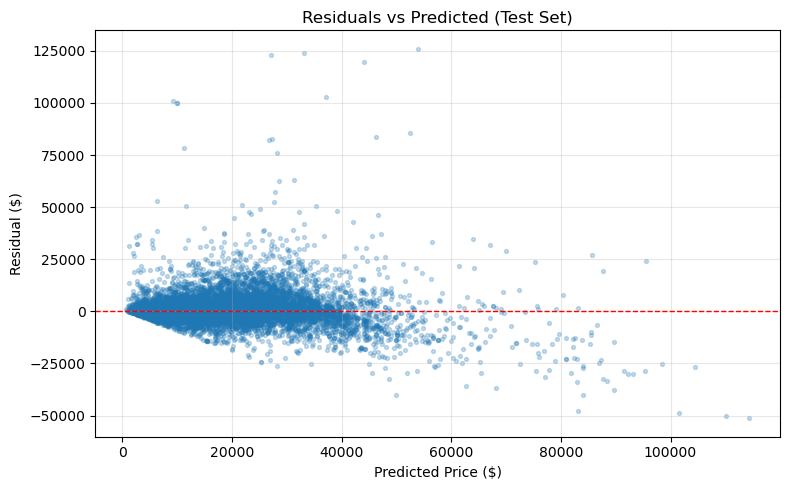


Median % error by drive:
drive
NaN    21.915896
rwd    21.389323
4wd    19.028855
fwd    18.758486
Name: abs_pct_err, dtype: float64

Median % error by type:
type
bus            88.352429
NaN            27.962881
offroad        25.086081
mini-van       20.352494
van            20.188729
truck          20.177729
convertible    19.106561
sedan          18.873896
SUV            18.288155
hatchback      18.128785
Name: abs_pct_err, dtype: float64

Median % error by manufacturer:
manufacturer
fiat            82.767227
ferrari         81.943472
aston-martin    65.337456
NaN             38.566130
porsche         32.015698
mini            28.165885
chevrolet       23.973917
saturn          23.839530
pontiac         23.676269
dodge           23.461438
Name: abs_pct_err, dtype: float64

Median % error by odo_bin:
odo_bin
NaN                     39.289267
(150000.0, 300000.0]    26.486856
(100000.0, 150000.0]    21.755059
(60000.0, 100000.0]     19.740883
(-0.001, 30000.0]       16.302318
(30000

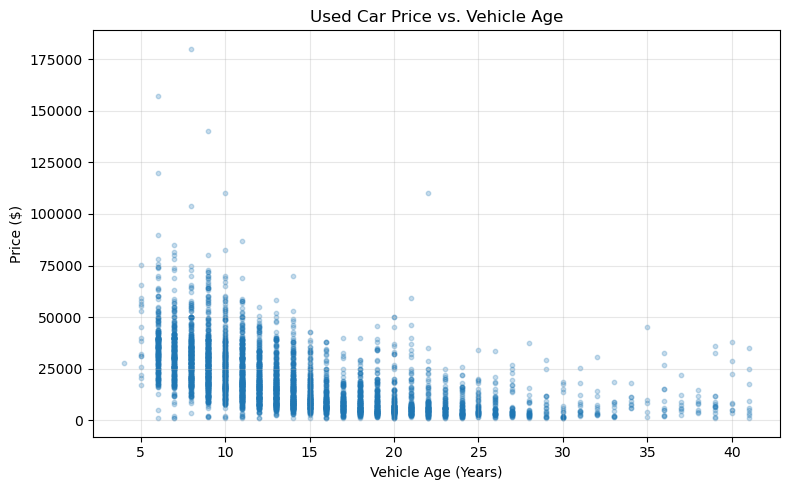

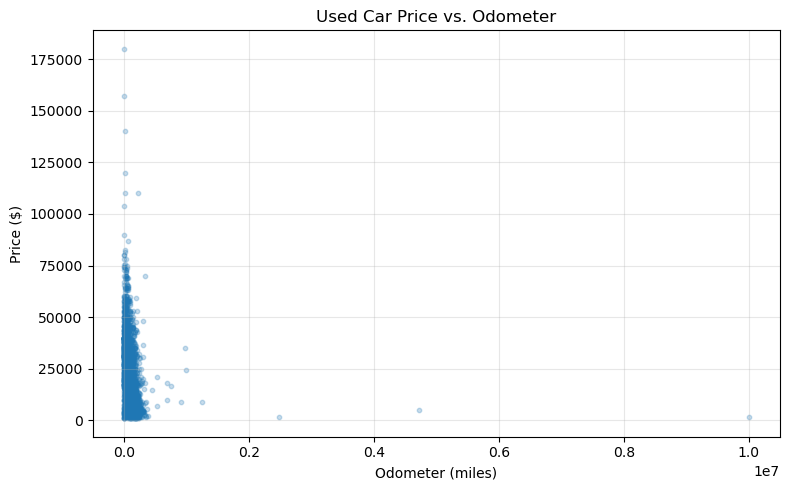


Done.


In [9]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
%matplotlib inline

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})
# Percent effect on price ≈ (exp(beta) - 1) * 100 (since target is log_price)
coef_df['pct_effect_%'] = (np.exp(coef_df['coefficient']) - 1.0) * 100
coef_df = coef_df.sort_values('coefficient', ascending=False)

print("\n=== Top positive drivers (log-price; numeric per +1 SD) ===")
print(coef_df.head(15).to_string(index=False))
print("\n=== Top negative drivers ===")
print(coef_df.tail(15).to_string(index=False))

# Optional: save coefficients
out_dir = os.path.dirname(CSV_PATH) if os.path.dirname(CSV_PATH) else os.getcwd()
coef_path = os.path.join(out_dir, "ridge_coefficients.csv")
coef_df.to_csv(coef_path, index=False)
print(f"\nSaved coefficients to: {coef_path}")
# -------------------------
# 8) DIAGNOSTICS: Residuals + Subgroup errors
# -------------------------
# Residuals vs Predicted on $ scale
y_true_dollars = np.exp(y_test)
y_pred_dollars = np.exp(y_pred_log)
resid_dollars = y_true_dollars - y_pred_dollars

plt.figure(figsize=(8,5))
plt.scatter(y_pred_dollars, resid_dollars, alpha=0.25, s=8)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual ($)')
plt.title('Residuals vs Predicted (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Median % error by subgroup (examples)
test_diag = X_test.copy()
test_diag['y_true_$'] = y_true_dollars
test_diag['y_pred_$'] = y_pred_dollars
test_diag['abs_pct_err'] = np.abs(test_diag['y_pred_$'] - test_diag['y_true_$']) / test_diag['y_true_$'] * 100
for col in ['drive', 'type', 'manufacturer', 'odo_bin']:
    if col in test_diag.columns:
        print(f"\nMedian % error by {col}:")
        print(test_diag.groupby(col, dropna=False,observed=False)['abs_pct_err'].median().sort_values(ascending=False).head(10))
# -------------------------
# 9) QUICK PLOTS (EDA)
# -------------------------
plot_df = df.sample(min(5000, len(df)), random_state=RANDOM_STATE)
plt.figure(figsize=(8,5))
plt.scatter(plot_df['age'], plot_df['price'], alpha=0.25, s=10)
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Price ($)')
plt.title('Used Car Price vs. Vehicle Age')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if 'odometer' in plot_df.columns:
    plt.figure(figsize=(8,5))
    plt.scatter(plot_df['odometer'], plot_df['price'], alpha=0.25, s=10)
    plt.xlabel('Odometer (miles)')
    plt.ylabel('Price ($)')
    plt.title('Used Car Price vs. Odometer')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
print("\nDone.")